<a href="https://colab.research.google.com/github/Sourjya261/IDRid_EX_Segmentation/blob/main/training_cropnblur_resunet_with_improved_skip_connections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
import matplotlib.pyplot as plt
from PIL import Image


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense,MaxPooling2D,Reshape,Multiply
from tensorflow.keras.models import Model

def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x
def squeeze_excite_block(inputs, ratio=16):
    init = inputs       ## (b, 128, 128, 32)
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)     ## (b, 32)   -> (b, 1, 1, 32)
    se = Reshape(se_shape)(se)
    se = Dense(filters//ratio, activation="relu", use_bias=False)(se)
    se = Dense(filters, activation="sigmoid", use_bias=False)(se)

    x = Multiply()([inputs, se])
    return x

def residual_block(inputs, num_filters):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)

    """ Shortcut Connection """
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = x + s
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters)
    #x = squeeze_excite_block(x)
    return x

def build_resunet(input_shape):
    inputs = Input(input_shape)

    """ Encoder 1 """
    x = Conv2D(64, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    s = x
    x = Conv2D(64, 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    x = batchnorm_relu(x)
    x = Conv2D(64, 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    
    c1 = x + s
    p1 = MaxPooling2D((2,2))(c1)
    s1 = residual_block(c1,32)

    """ Encoder 2 and 3 """
    c2 = residual_block(p1, 64)
    p2 = MaxPooling2D((2,2))(c2)
    s2 = residual_block(c2,64)
    
    c3 = residual_block(p2, 128)
    p3 = MaxPooling2D((2,2))(c3)
    s3 = residual_block(c3,128)

    c4 = residual_block(p3, 256)
    p4 = MaxPooling2D((2,2))(c4)
    s4 = residual_block(c4,256)

    """ Bridge """
    b = residual_block(p4, 512)

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    """ Classifier """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    """ Model """
    model = Model(inputs, outputs)
    return model

76


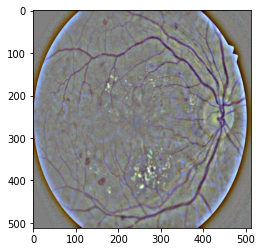

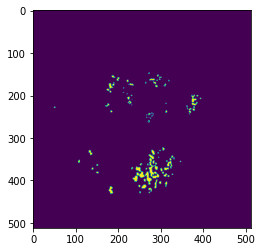

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/cropnblur/train/"
images = sorted(glob(os.path.join(path, "images_aug", "*.jpg")))
masks = sorted(glob(os.path.join(path,"masks_aug","*tif")))
x=cv2.imread(images[0])
y=cv2.imread(masks[0],cv2.IMREAD_GRAYSCALE)
x = cv2.resize(x,(512,512),interpolation=cv2.INTER_AREA)
x = x/255.0
y = cv2.resize(y,(512,512),interpolation=cv2.INTER_AREA)
print(np.max(y))
y = y.astype(np.float32)
y = y/np.max(y)
y = y>0.5
plt.imshow(x)
plt.show()
plt.imshow(y)
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
def preprocess(img, sigmaX=10):  
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), sigmaX), -4, 128)

    return img

In [ ]:
""" Global Parameters """
H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path,split=0.2):

    images = sorted(glob(os.path.join(path, "images_aug", "*.jpg")))
    masks = sorted(glob(os.path.join(path, "masks_aug", "*.tif")))
    
    print(len(images))
    print(len(masks))
    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)


    return (train_x, train_y), (valid_x, valid_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    #x = preprocess(x,5)
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    threshold,thresh = cv2.threshold(x,75,255,cv2.THRESH_BINARY)
    x = thresh
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=4):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files")

    """ Hyperparameters """
    batch_size = 4
    lr = 1e-4
    num_epochs = 100
    model_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files/", "double_unet_cropnblur.h5")
    csv_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files/", "double_unet_cropnblur.csv")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/cropnblur/train/"
    (train_x, train_y),(test_x, test_y) = load_data(dataset_path)
    train_x, train_y = shuffling(train_x, train_y)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    
    print(f"Test: {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch_size)
    valid_dataset = tf_dataset(test_x, test_y, batch_size)

    train_steps = len(train_dataset)
    valid_steps = len(valid_dataset)

    """ Model """
    model = build_resunet((H, W, 3))
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
    ]


216
216
Train: 173 - 173
Test: 43 - 43


NameError: ignored

In [ ]:
model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks
)

Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 0.9826 - dice_coef: 0.0172 - iou: 0.0087 - recall_1: 0.8214 - precision_1: 0.0096
Epoch 1: val_loss improved from inf to 0.98263, saving model to /content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files/mmultiresunet_cropnblur.h5
44/44 [==============================] - 158s 3s/step - loss: 0.9826 - dice_coef: 0.0172 - iou: 0.0087 - recall_1: 0.8214 - precision_1: 0.0096 - val_loss: 0.9826 - val_dice_coef: 0.0180 - val_iou: 0.0092 - val_recall_1: 0.9959 - val_precision_1: 0.0088 - lr: 1.0000e-04
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 0.7552 - dice_coef: 0.2472 - iou: 0.1531 - recall_1: 0.5843 - precision_1: 0.0289
Epoch 2: val_loss did not improve from 0.98263
44/44 [==============================] - 72s 2s/step - loss: 0.7552 - dice_coef: 0.2472 - iou: 0.1531 - recall_1: 0.5843 - precision_1: 0.0289 - val_loss: 1.0000 - val_dice_coef: 2.9129e-19 - val_iou: 2.9129e-19 - val_rec

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.utils import CustomObjectScope
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import pandas as pd

In [ ]:
def read_image_(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (H, W))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    return ori_x, x

def read_mask_(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (H, W))
    threshold,thresh = cv2.threshold(x,75,255,cv2.THRESH_BINARY)
    x = thresh
    ori_x = x
    x = x/np.max(x)
    x = x.astype(np.int32)
    return ori_x, x

In [ ]:
def save_result(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255.0

    ori_y = np.expand_dims(ori_y, axis=-1)  ## (256, 256, 1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1) ## (256, 256, 3)

    y_pred = np.expand_dims(y_pred, axis=-1)    ## (256, 256, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255.0 ## (256, 256, 3)

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [ ]:
create_dir("/content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/resunet_improved_skip_results")

""" Loading the model """
with CustomObjectScope({"iou": iou, "dice_coef": dice_coef, "dice_loss": dice_loss}):
  model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files/mmultiresunet_cropnblur.h5")

""" Predict the mask and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        
      
        name = x.split("/")[-1]

        """ Reading the image and mask. """
        ori_x, x = read_image_(x)
        ori_y, y = read_mask_(y)

        if(np.max(ori_y)!=0):

            """ Predict the mask """
            y_pred = model.predict(x)[0] > 0.1
            y_pred = np.squeeze(y_pred, axis=-1)
            y_pred = y_pred.astype(np.int32)

            """ Save the image """
            save_image_path = f"/content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/resunet_improved_skip_results/{name}"
            save_result(ori_x, ori_y, y_pred, save_image_path)

            """ Flattening the numpy arrays. """
            y = y.flatten()
            y_pred = y_pred.flatten()

            """ Calculating metrics values """
            acc_value = accuracy_score(y, y_pred)
            f1_value = f1_score(y, y_pred, labels=[0, 1], average="micro")
            jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="micro")
            recall_value = recall_score(y, y_pred, labels=[0, 1], average="micro")
            precision_value = precision_score(y, y_pred, labels=[0, 1], average="micro")
            if precision_value != 0:
              SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")

""" Saving all the results """
df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("/content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files/resunet_improved_skip_score.csv")

100%|██████████| 43/43 [00:31<00:00,  1.38it/s]

Accuracy: 0.99574
F1: 0.99574
Jaccard: 0.99157
Recall: 0.99574
Precision: 0.99574


In [ ]:

with CustomObjectScope({"iou": iou, "dice_coef": dice_coef, "dice_loss": dice_loss}):
  model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files/mmultiresunet_cropnblur.h5")

In [ ]:
model_1  = tf.keras.models.clone_model(model)

In [ ]:
for layer in model_1.layers:
  layer.trainable = False

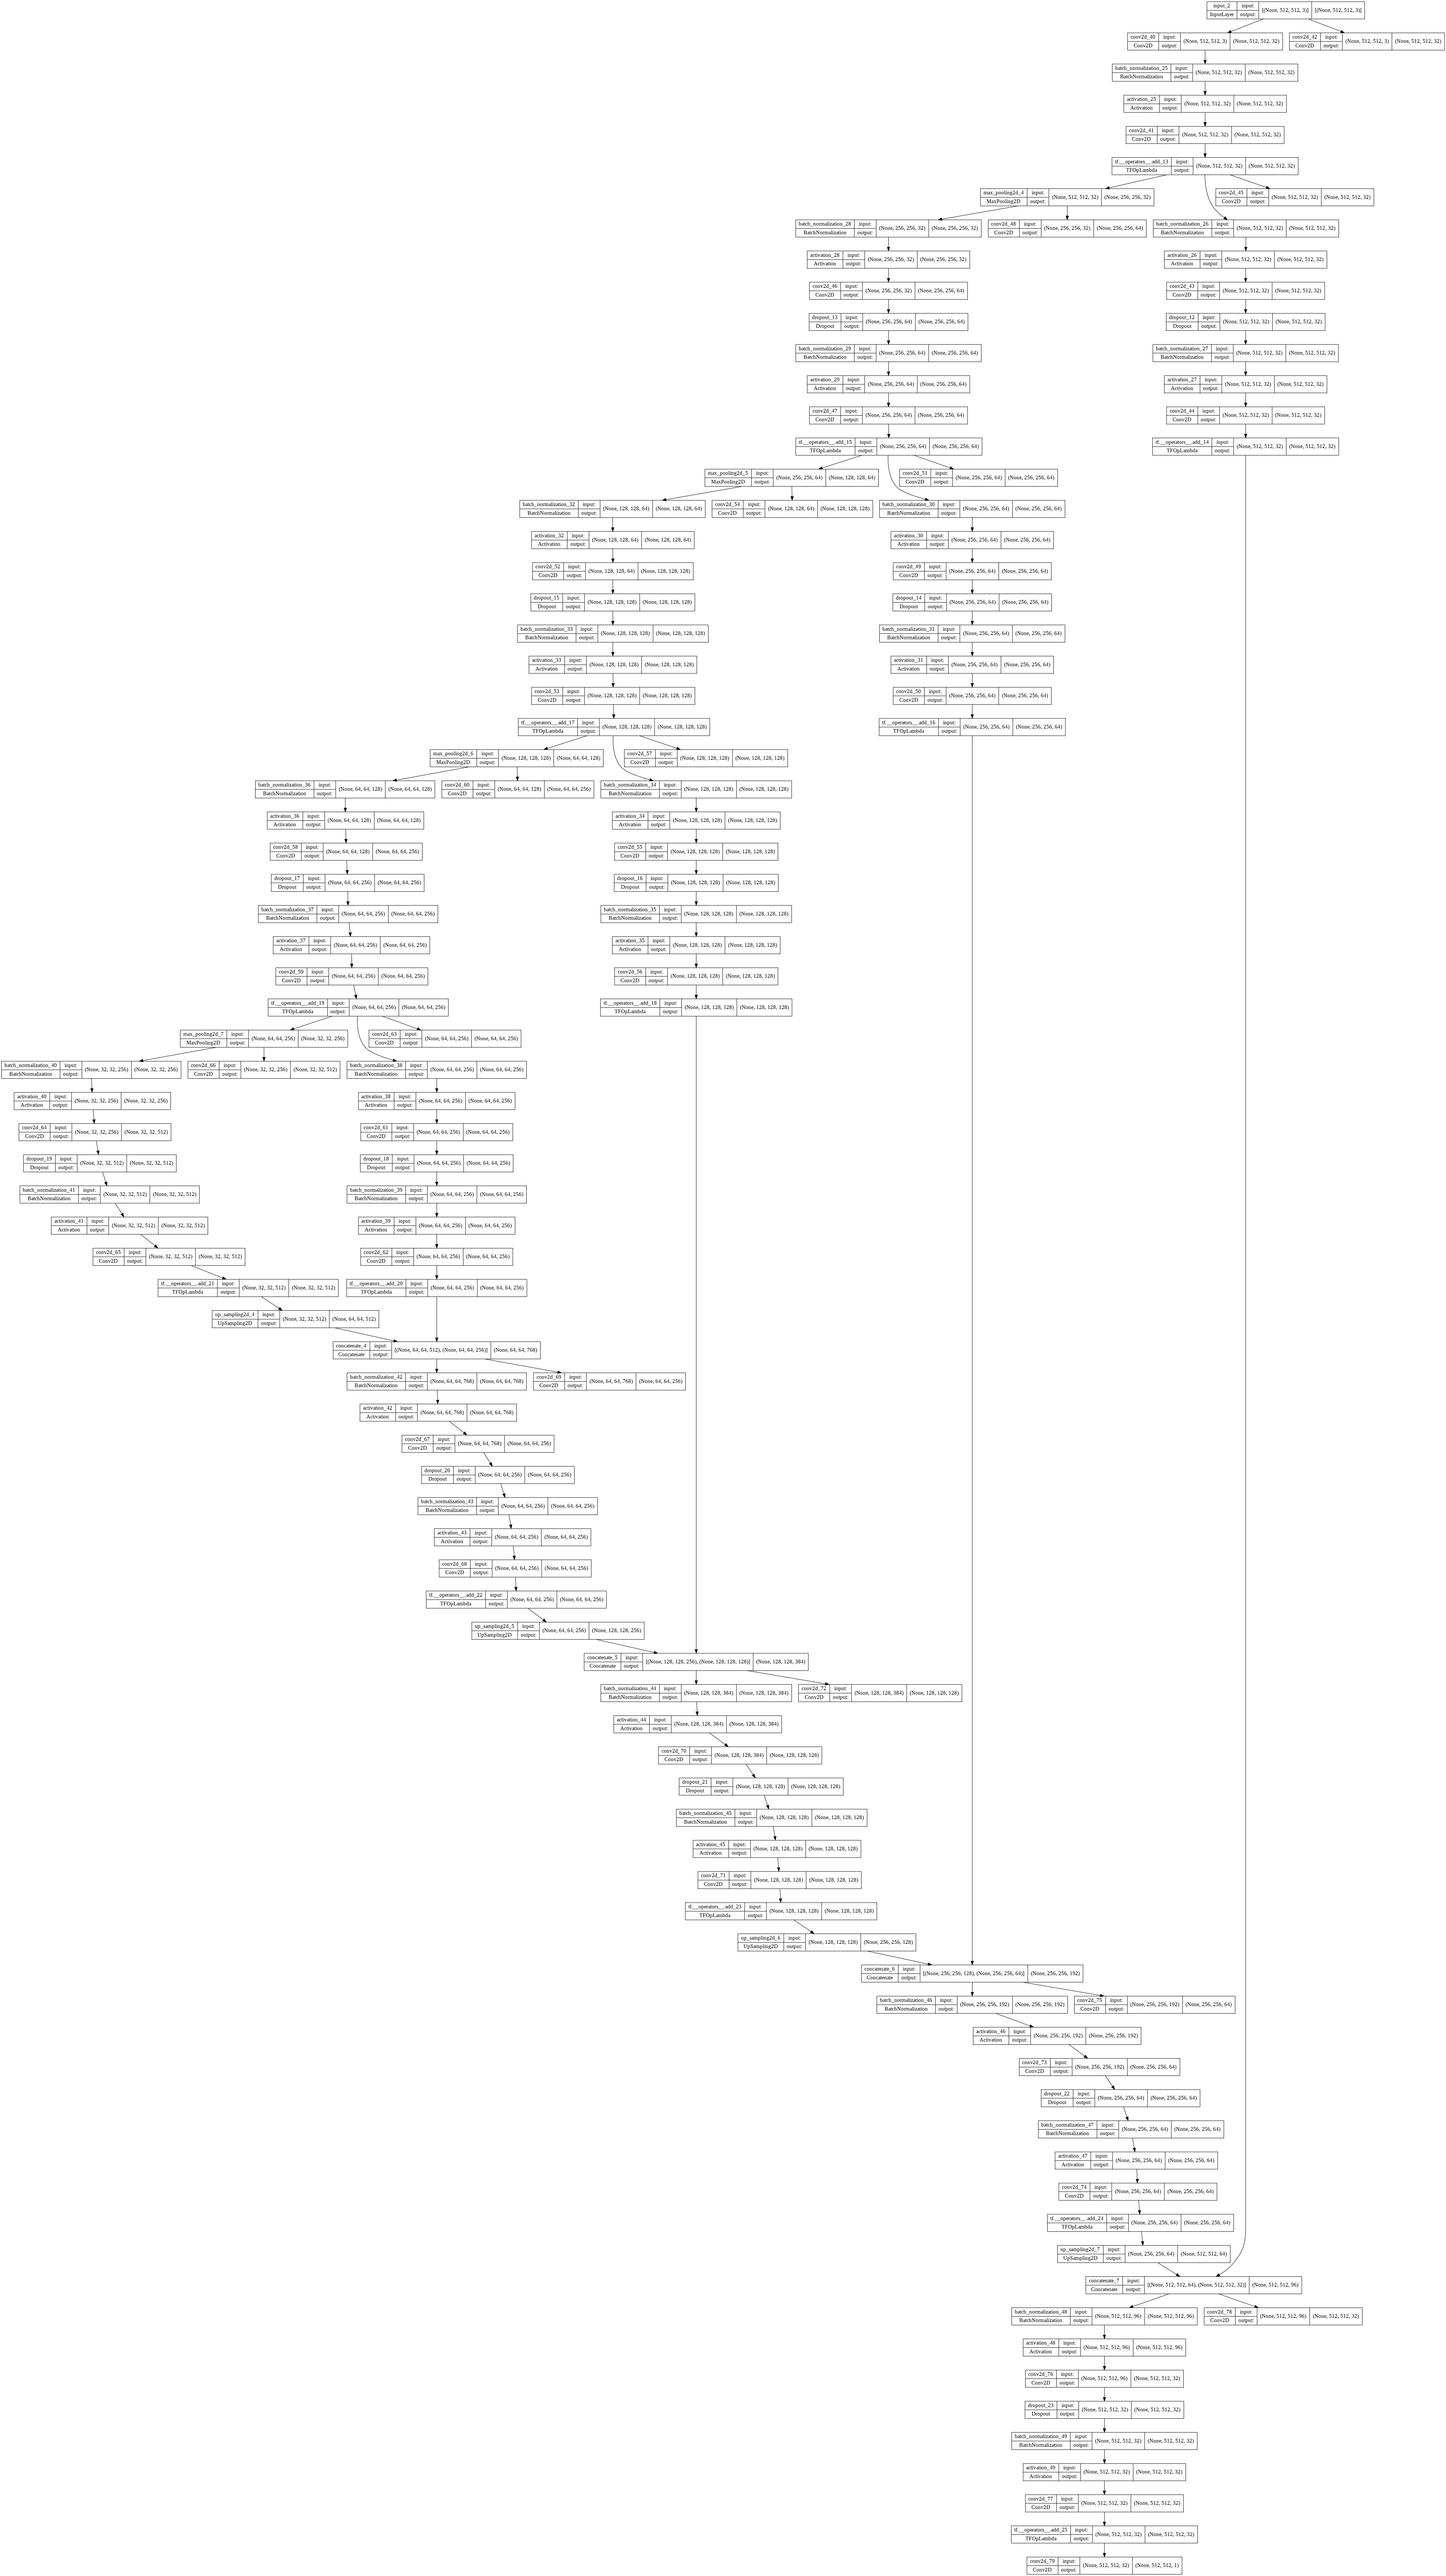

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense,MaxPooling2D,Reshape,Multiply,GlobalAveragePooling2D
from tensorflow.keras.models import Model

def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x
def squeeze_excite_block(inputs, ratio=8):
    init = inputs       ## (b, 128, 128, 32)
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)     ## (b, 32)   -> (b, 1, 1, 32)
    se = Reshape(se_shape)(se)
    se = Dense(filters//ratio, activation="relu", use_bias=False)(se)
    se = Dense(filters, activation="sigmoid", use_bias=False)(se)

    x = Multiply()([inputs, se])
    return x

def conv_block(inputs, num_filters):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = squeeze_excite_block(x)
    return x

def decoder_block(inputs, skip1,s,num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip1 ,s])
    x = conv_block(x, num_filters)
    
    return x

def build_se_unet(input_shape,model_1):
    inputs = Input(input_shape)
    
    # x = model_1(inputs)
    
    model = Model(inputs=model_1.input,outputs=[model_1.get_layer("conv2d_79").output,model_1.get_layer("tf.__operators__.add_14").output,model_1.get_layer("tf.__operators__.add_16").output, model_1.get_layer("tf.__operators__.add_18").output,model_1.get_layer("tf.__operators__.add_20").output])

    x,s1,s2,s3,s4  = model(inputs)
    '''
    s1 = model_1.get_layer("tf.__operators__.add_14").output
    s2 = model_1.get_layer("tf.__operators__.add_16").output
    s3 = model_1.get_layer("tf.__operators__.add_18").output
    s4 = model_1.get_layer("tf.__operators__.add_20").output
    '''
    x = x*inputs
    """ Encoder 1 """
    x = Conv2D(32, 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    x = batchnorm_relu(x)
    x = Conv2D(32, 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    x = squeeze_excite_block(x)
    
    c1 = x 
    p1 = MaxPooling2D((2,2))(c1)


    """ Encoder 2 and 3 """
    c2 = conv_block(p1, 64)
    p2 = MaxPooling2D((2,2))(c2)

    
    c3 = conv_block(p2, 128)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = conv_block(p3, 256)
    p4 = MaxPooling2D((2,2))(c4)

    """ Bridge """
    b = conv_block(p4, 512)

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, c4,s4, 256)
    d2 = decoder_block(d1, c3,s3,128)
    d3 = decoder_block(d2, c2,s2, 64)
    d4 = decoder_block(d3, c1,s1, 32)

    """ Classifier """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    """ Model """
    model = Model(inputs, outputs)
    return model

In [ ]:
model_2 = build_se_unet((512,512,3),model_1)

In [ ]:
model_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           [(None, 512, 512, 1  9956033     ['input_2[0][0]']                
                                ),                                                                
                                 (None, 512, 512, 3                                               
                                2),                                                               
                                 (None, 256, 256, 6                                         

In [ ]:
""" Global Parameters """
H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path,split=0.2):

    images = sorted(glob(os.path.join(path, "images_aug", "*.jpg")))
    masks = sorted(glob(os.path.join(path, "masks_aug", "*.tif")))
    
    print(len(images))
    print(len(masks))
    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)


    return (train_x, train_y), (valid_x, valid_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    #x = preprocess(x,5)
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    threshold,thresh = cv2.threshold(x,75,255,cv2.THRESH_BINARY)
    x = thresh
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=4):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files")

    """ Hyperparameters """
    batch_size = 4
    lr = 1e-4
    num_epochs = 100
    model_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files/", "double_unet_cropnblur.h5")
    csv_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files/", "double_unet_cropnblur.csv")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/Colab Notebooks/IDRID_Dataset/cropnblur/train/"
    (train_x, train_y),(test_x, test_y) = load_data(dataset_path)
    train_x, train_y = shuffling(train_x, train_y)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    
    print(f"Test: {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch_size)
    valid_dataset = tf_dataset(test_x, test_y, batch_size)

    train_steps = len(train_dataset)
    valid_steps = len(valid_dataset)

    """ Model """
    model = build_se_unet((H, W, 3),model_1)
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
    ]


216
216
Train: 173 - 173
Test: 43 - 43


In [ ]:
model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks
)

Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 0.9657 - dice_coef: 0.0340 - iou: 0.0174 - recall_1: 0.8566 - precision_1: 0.0234
Epoch 1: val_loss improved from inf to 0.98376, saving model to /content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files/double_unet_cropnblur.h5
44/44 [==============================] - 203s 5s/step - loss: 0.9657 - dice_coef: 0.0340 - iou: 0.0174 - recall_1: 0.8566 - precision_1: 0.0234 - val_loss: 0.9838 - val_dice_coef: 0.0168 - val_iou: 0.0085 - val_recall_1: 0.0790 - val_precision_1: 0.0473 - lr: 1.0000e-04
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 0.8974 - dice_coef: 0.1020 - iou: 0.0553 - recall_1: 0.7329 - precision_1: 0.1261
Epoch 2: val_loss improved from 0.98376 to 0.98239, saving model to /content/drive/MyDrive/Colab Notebooks/IDRID_EX_segementation/files/double_unet_cropnblur.h5
44/44 [==============================] - 77s 2s/step - loss: 0.8974 - dice_coef: 0.1020 - iou: 0.0553 - recal

KeyboardInterrupt: ignored